In [2]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, make_scorer,r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
import shap
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import warnings
warnings.filterwarnings("ignore")

c:\Users\thibc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement des données

In [3]:
train_data = pd.read_csv('data/x_train.csv')  
y_data = pd.read_csv('data/y_train.csv')
test_data = pd.read_csv('data/x_test.csv')

### Visualisation des données

Taille du dataset :

In [3]:
print("Number of observations:",train_data.shape[0],"\n")
print("Number of columns:",train_data.shape[1])

Number of observations: 202933 

Number of columns: 14


Visualisation d'un échantillon :

In [4]:
df_display = train_data.drop(columns=["ID"]).applymap('{:.3f}'.format)
df_display.head(10)

,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
0,0.098,-0.176,-0.086,-0.041,-0.021,0.198,0.055,-0.009,0.002,1.007,1.013,1.001,0.999
1,0.000,-0.066,0.036,0.033,-0.001,2.568,1.883,0.779,0.262,0.971,0.997,1.002,1.013
2,0.000,0.191,0.188,0.144,0.093,-0.147,-0.021,0.040,0.066,1.302,0.905,0.954,0.986
3,0.761,-0.151,-0.084,-0.049,-0.018,0.045,0.102,0.013,0.004,1.014,1.004,1.012,1.009
4,0.108,0.075,0.043,0.026,0.019,-0.056,-0.011,0.010,0.012,0.999,1.005,1.000,1.000
5,0.000,-0.363,-0.168,-0.077,-0.038,1.462,0.535,0.140,0.054,0.936,0.867,0.983,1.004
6,0.000,-0.011,0.029,0.030,0.052,0.145,0.076,0.056,0.060,2.260,0.423,0.902,0.993
7,0.000,0.044,0.034,0.009,0.047,0.143,0.024,0.008,0.004,1.082,1.052,0.990,1.027
8,0.000,-0.202,-0.096,-0.026,0.041,0.371,0.133,0.063,0.061,1.602,0.822,0.934,1.000
9,0.000,-3.131,-2.283,-1.301,-0.381,0.740,0.281,0.137,0.132,0.944,0.687,0.964,0.995


Quelques statistiques descriptives du dataset :

In [29]:
df_display = df_display.astype(float)
summary_stats = df_display.agg({x: ['count', 'median', 'mean', 'std', 'skew', 'kurtosis', 'min', 'max'] for x in df_display.columns}).applymap('{:.2f}'.format)
summary_stats.head(15)

,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
count,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00,202933.00
median,0.09,-0.00,0.02,0.02,0.01,0.16,0.07,0.04,0.03,1.01,0.93,0.99,1.00
mean,0.23,-0.30,-0.25,-0.16,-0.05,0.89,0.45,0.18,0.08,1.19,0.86,1.01,1.00
std,0.34,1.42,1.25,0.85,0.36,2.43,1.58,0.82,0.39,1.83,0.31,1.17,0.02
skew,1.22,-4.23,-4.73,-5.47,-6.18,4.33,7.51,11.24,13.36,17.71,4.95,33.13,-5.28
kurtosis,-0.28,23.62,29.13,38.93,50.32,22.58,72.89,153.37,211.66,357.07,78.22,1248.83,43.06
min,0.00,-13.02,-11.85,-9.12,-4.17,-2.83,-0.79,-0.22,-0.15,0.02,0.03,0.15,0.71
max,0.96,2.54,2.87,2.00,0.84,28.25,28.71,20.51,10.71,48.03,6.63,55.70,1.06


Visualisaion des distributions des variables explicatives :

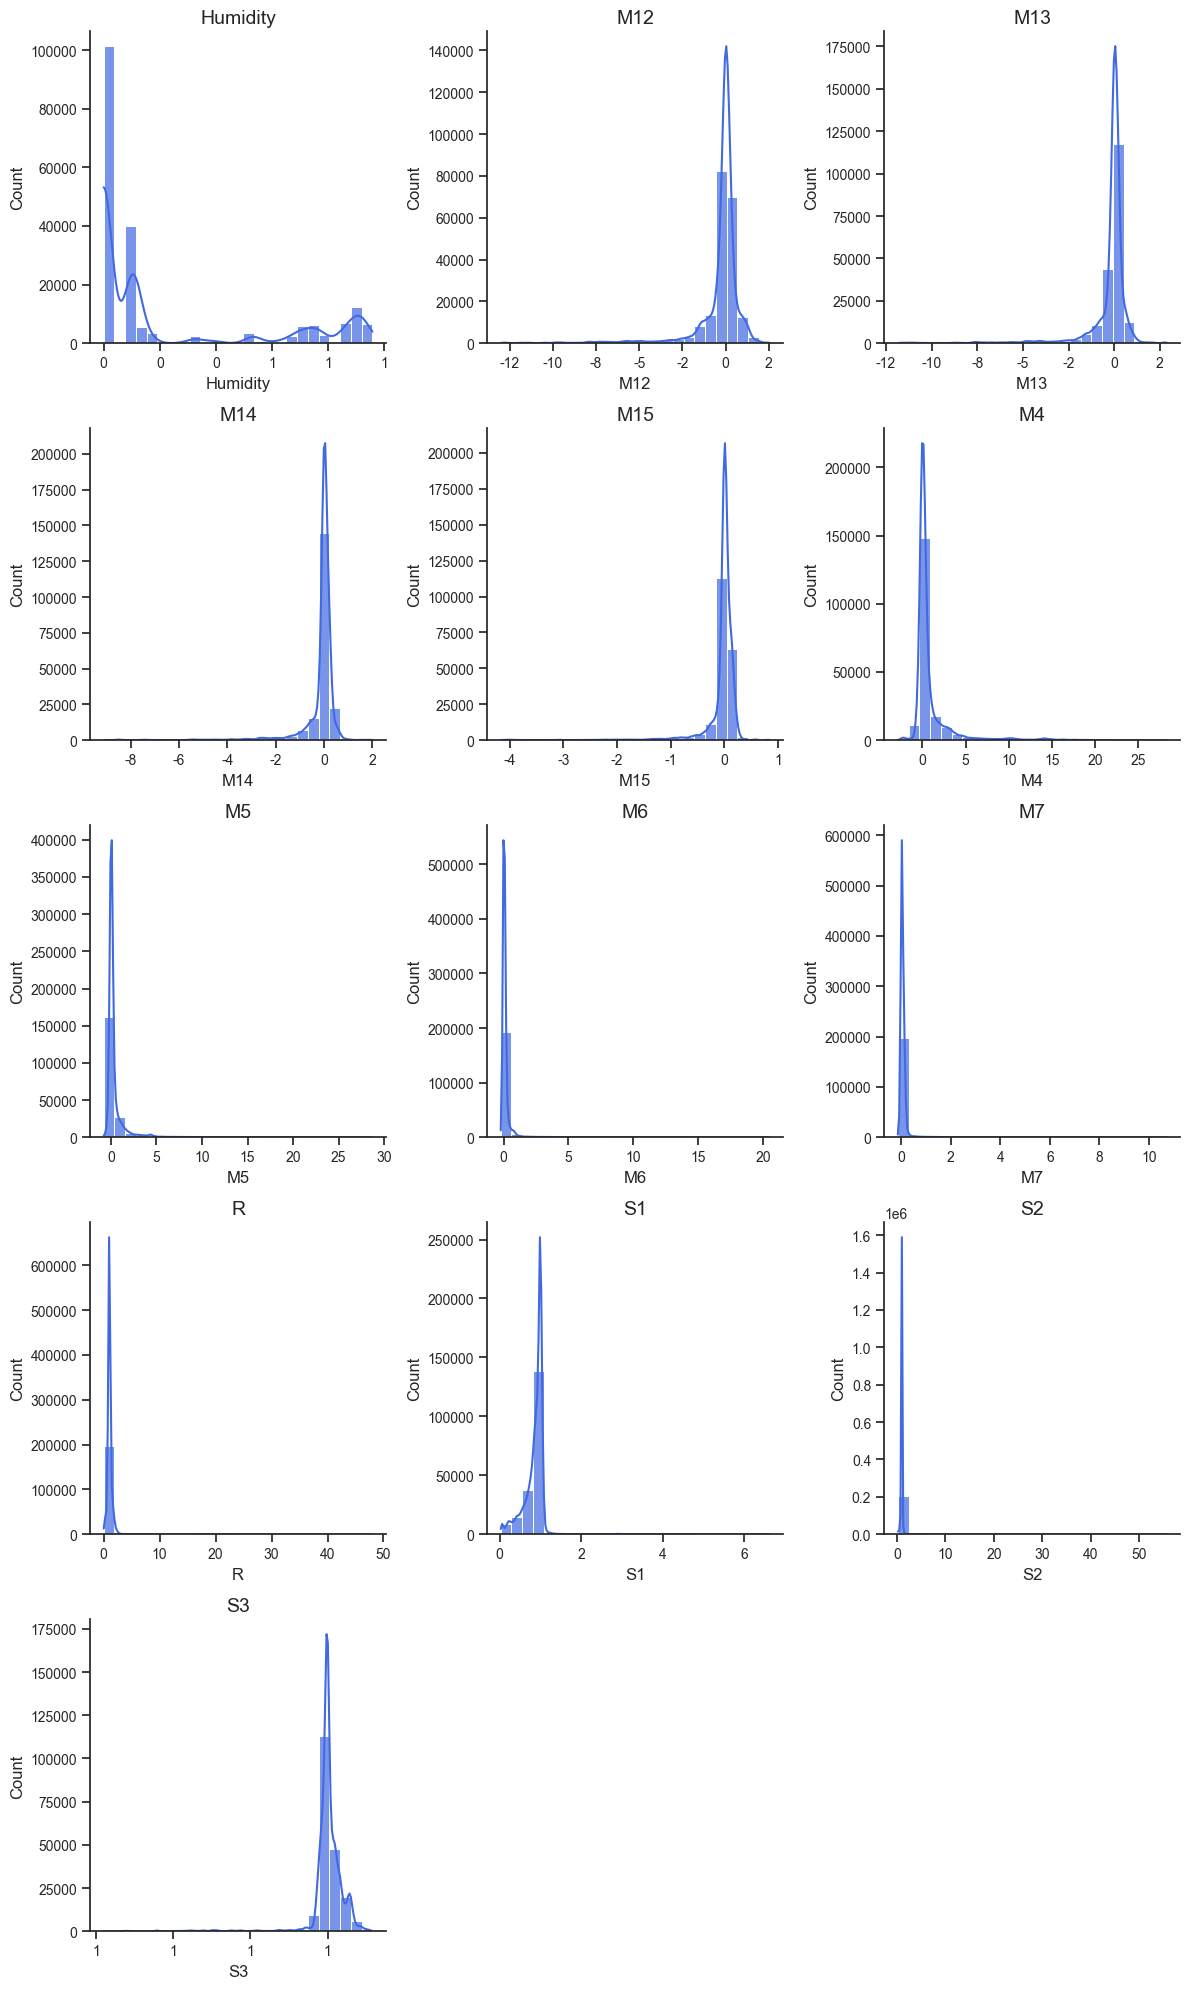

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

params = {
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "font.size": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [6, 6]
}
plt.rcParams.update(params)

def tick_fmt(number, pos):
    return f"{number:,.0f}"

num_vars = len(df_display.columns)
num_cols = 3
num_rows = -(-num_vars // num_cols)

plt.figure(figsize=(12, 4 * num_rows))

for i, var in enumerate(df_display.columns):
    plt.subplot(num_rows, num_cols, i + 1)

    sns.histplot(df_display[var], bins=25, color="royalblue", alpha=0.7, kde=True)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(tick_fmt))
    plt.title(var)

plt.tight_layout()
plt.show()

Corrélation des variables explicatives :

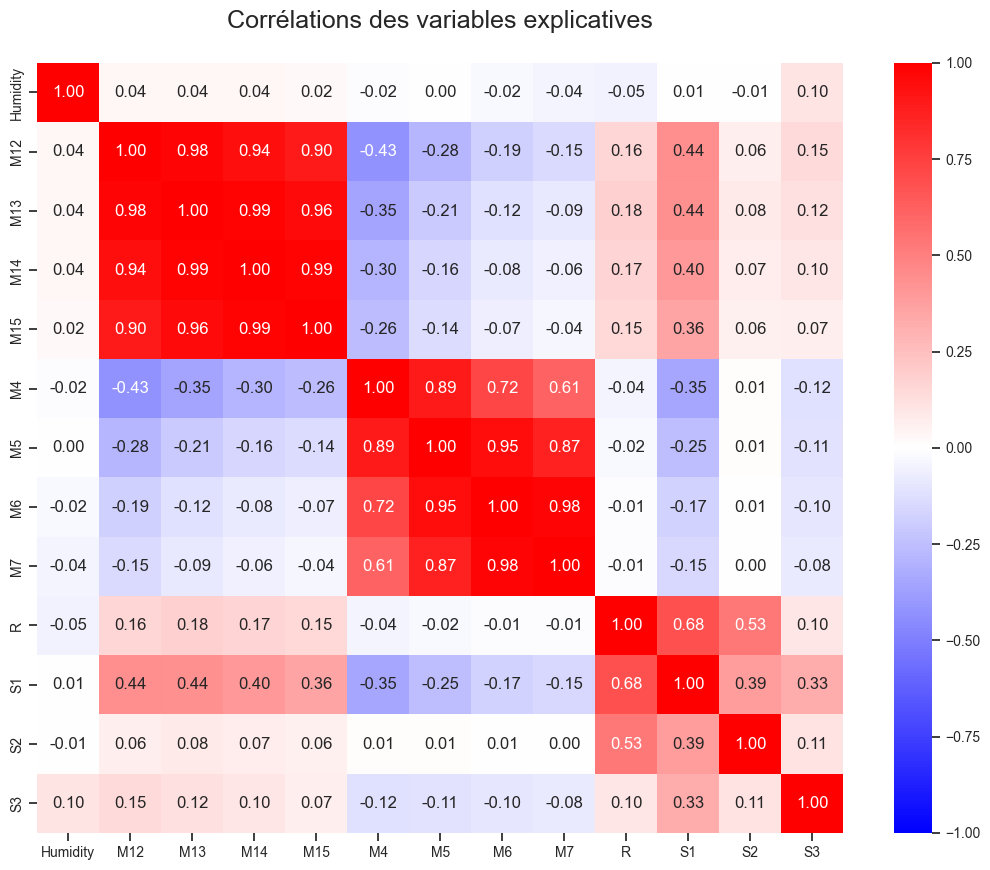

In [43]:
correlations = df_display.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(correlations, annot=True, cmap='bwr', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 12})
plt.title('Corrélations des variables explicatives\n', fontsize=18)
plt.show()

In [4]:
def custom_weighted_rmse(y_true, y_pred):
    weights = np.where(y_true < 0.5, 1, 1.2)
    error_per_class = weights * (y_true - y_pred) ** 2
    mean_error = np.mean(error_per_class)
    return np.sqrt(mean_error)

custom_scorer = make_scorer(custom_weighted_rmse, greater_is_better=False)

## Data Preparation

In [30]:
# Suppression de la colonne 'ID' (pas utile pour l'entraînement)
X = train_data.drop(columns=['ID'])
y = y_data.drop(columns=['ID'])

# Diviser les données en ensemble d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Application d un standard scaler

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

### Polynomial features

In [6]:
#Now, we extract polynomial features and interactions up to a degree of 2
poly = PolynomialFeatures(degree=2)
poly.fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (162346, 13)
X_train_poly.shape: (162346, 105)


## Etude classique 1 seul Model pour prédire 

### Selection des Modeles

On cherche à tester sur un grand nombre de datasets afin de voir si un modele marche mieux ou nom 

In [ ]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(X_train_scaled, y_train)
    # Évaluation du modèle
    y_pred = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred) 
    custom_rmse = custom_weighted_rmse(y_val, y_pred)
    # Validation croisée
    #cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=custom_scorer)
    res.append([mod.__class__.__name__,custom_rmse, mse,r2,])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso


c:\Users\bapdu\COMMUN\Dauphine\Identification-Gaz-Toxiques-BERTIN\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Model: ElasticNet


c:\Users\bapdu\COMMUN\Dauphine\Identification-Gaz-Toxiques-BERTIN\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: KNeighborsRegressor


In [23]:
res = pd.DataFrame(res,columns=["model","custom_rmse","mse","r2"]).sort_values(by="custom_rmse",ascending=False)
# res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res

,model,custom_rmse,mse,r2
3,Lasso,0.217702,0.041588,0.043445
4,ElasticNet,0.217702,0.041588,0.043445
2,Ridge,0.178308,0.028143,0.272862
1,LinearRegression,0.178304,0.028143,0.272863
7,KNeighborsRegressor,0.026284,0.000649,0.973690
0,XGBRegressor,0.022887,0.000487,0.947358
5,DecisionTreeRegressor,0.014776,0.000204,0.993547
6,RandomForestRegressor,0.009530,0.000086,0.997001


Le meilleur model semble etre le random Forest Regressor. On va donc essayer d optimiser les parametres

### Optimisation des hyperparamètres - Random Forest

On va commencer par utiliser un modèle de Random Forest simple que l'on va evaluer

In [29]:
model_rf = RandomForestRegressor(n_estimators=5, max_depth=7, min_samples_split=0.01, min_samples_leaf=30, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
rmse = custom_weighted_rmse(y_val, y_pred)
print(f"Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : {rmse}")

Erreur quadratique moyenne pondérée (RMSE) sur les données de validation : 0.1191449218902717


Debut de l'optimisation des hyperparamètres

In [ ]:
param_grid = {
    'n_estimators': [11,12,13],
    'max_depth': [15,20],
    'min_samples_split': [0.01],
    'min_samples_leaf': [30]
}
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring=custom_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
# Meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Meilleurs hyperparamètres : {'max_depth': 20, 'min_samples_leaf': 30, 'min_samples_split': 0.01, 'n_estimators': 12}


In [19]:
# Évaluation finale sur les données de validation
y_pred = best_model.predict(X_val_poly)
best_mse = mean_squared_error(y_val, y_pred)
best_r2 = r2_score(y_val, y_pred)
custom_mse = custom_weighted_rmse(y_val, y_pred)
print(f"Best Mean Squared Error: {best_mse}")
print(f"Best R^2 Score: {best_r2}")
print(f"Custom MSE sur les données de validation : {custom_mse}")

Best Mean Squared Error: 0.006941095460412228
Best R^2 Score: 0.736276503833478
Custom MSE sur les données de validation : 0.08747619645254948


In [ ]:
# Évaluation finale sur les données de validation
y_pred = best_model.predict(X_val_poly)
best_mse = mean_squared_error(y_val, y_pred)
best_r2 = r2_score(y_val, y_pred) 
custom_mse = custom_weighted_rmse(y_val, y_pred)
print(f"Best Mean Squared Error: {best_mse}")
print(f"Best R^2 Score: {best_r2}")
print(f"Custom MSE sur les données de validation : {custom_mse}")

Best Mean Squared Error: 0.007539696090108572
Best R^2 Score: 0.7263825866396201
Custom MSE sur les données de validation : 0.09115404934287714


In [14]:
# Effectuer une validation croisée à 5 folds
best_cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=custom_scorer)
print(f"Best Cross-Validation Scores: {-best_cv_scores}")
print(f"Mean Best Cross-Validation Score : {-best_cv_scores.mean()}")

Best Cross-Validation Scores: [0.08968177 0.09232792 0.09127526 0.09227364 0.09024462]
Mean Best Cross-Validation Score : 0.09116064294290777


### Application des modeles avec Polynomial Features

In [9]:
models = {
    'XGBoost' : XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(n_estimators=5, max_depth=7, min_samples_split=0.01, min_samples_leaf=30, random_state=42),
    'K-Neighbors Regression': KNeighborsRegressor()}

res = list()
for mod in models.values() :
    print(f"Model: {mod.__class__.__name__}")
    # Initialiser le modèle
    model = mod
    # Entraîner le modèle de base
    model.fit(X_train_poly, y_train)
    # Évaluation du modèle
    y_pred = model.predict(X_val_poly)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred) 
    custom_rmse = custom_weighted_rmse(y_val, y_pred)
    # Validation croisée
    #cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=custom_scorer)
    res.append([mod.__class__.__name__,"Polynomial Features",custom_rmse, mse,r2,])

Model: XGBRegressor
Model: LinearRegression
Model: Ridge
Model: Lasso


c:\Users\bapdu\COMMUN\Dauphine\Identification-Gaz-Toxiques-BERTIN\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Model: ElasticNet


c:\Users\bapdu\COMMUN\Dauphine\Identification-Gaz-Toxiques-BERTIN\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Model: DecisionTreeRegressor
Model: RandomForestRegressor
Model: KNeighborsRegressor


In [10]:
res = pd.DataFrame(res,columns=["model","Type","custom_rmse","mse","r2"]).sort_values(by="custom_rmse",ascending=False)
display(res)

,model,Type,custom_rmse,mse,r2
3,Lasso,Polynomial Features,0.217702,0.041588,0.043445
4,ElasticNet,Polynomial Features,0.217137,0.041380,0.051383
2,Ridge,Polynomial Features,0.149709,0.020049,0.481192
1,LinearRegression,Polynomial Features,0.149502,0.019998,0.482415
6,RandomForestRegressor,Polynomial Features,0.117838,0.012479,0.611522
0,XGBRegressor,Polynomial Features,0.020608,0.000395,0.948205
7,KNeighborsRegressor,Polynomial Features,0.019814,0.000368,0.986720
5,DecisionTreeRegressor,Polynomial Features,0.017629,0.000286,0.989868


## Prediction de 1 model par Output

### Selection de modèles

In [ ]:
# Liste des modèles
models = {
    # 'XGBoost' : XGBRegressor(),
    # 'Linear Regression': LinearRegression(),
    # 'Ridge Regression': Ridge(),
    # 'Lasso Regression': Lasso(),
    # 'ElasticNet': ElasticNet(),
    'Support Vector Regression': SVR(),
    #'Decision Tree Regression': DecisionTreeRegressor(),
    #'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    #'K-Neighbors Regression': KNeighborsRegressor()
}

res = list()

for mod in models.values():
    print(f"Model: {mod.__class__.__name__}")
    
    # Initialiser le modèle MultiOutputRegressor avec le modèle de base
    multi_target_model = MultiOutputRegressor(mod)
    
    # Entraîner le modèle multi-cible
    multi_target_model.fit(X_train, y_train)
    
    # Prédictions pour toutes les cibles
    y_pred = multi_target_model.predict(X_val)
      
    # Calcul des métriques pour chaque colonne cible
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    custom_rmse = custom_weighted_rmse(y_val, y_pred)  # Remarque: tu peux ajuster cette fonction selon tes besoins
    
    # Ajouter les résultats dans la liste
    res.append([mod.__class__.__name__, custom_rmse, mse, r2])

Model: SVR


: 

In [ ]:
res = pd.DataFrame(res,columns=["model","custom_rmse","mse","r2"]).sort_values(by="custom_rmse",ascending=False)
# res["cv_mean"] = res['cv_score'].apply(lambda x : np.mean(x))
res.head(5)

### Interpretable Machine Learning

## Partial Dependence Plot (PDP)

<u>Objectif :</u>

Le Partial Dependence Plot permet de visualiser comment une caractéristique influence les prédictions d'un modèle, en moyennisant l'effet des autres caractéristiques. Il aide à comprendre l'impact global d'une variable sur le modèle, facilitant ainsi l'interprétation des résultats.

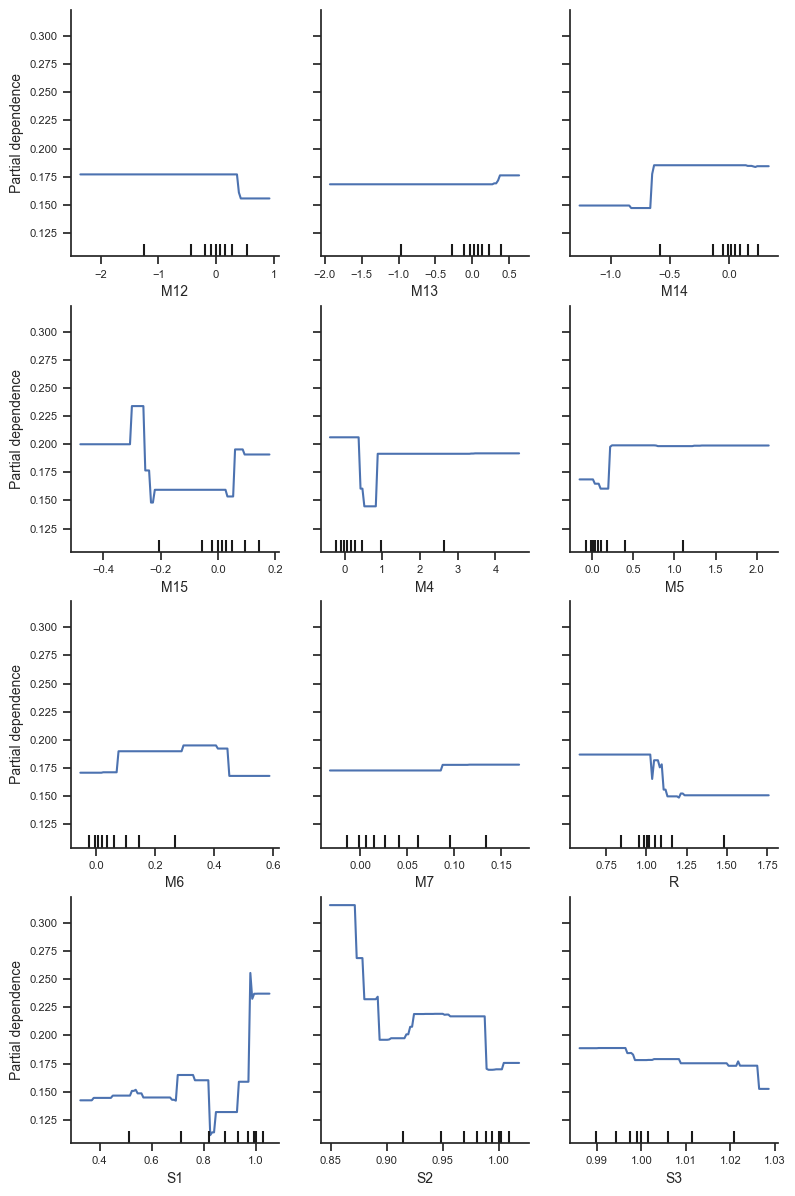

In [8]:
params = {
    "axes.labelsize":10,
    "axes.titlesize":12,
    "font.size":8,
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    'figure.figsize':[8,12]
}
plt.rcParams.update(params)
PartialDependenceDisplay.from_estimator(model_rf, X_train,
                                        [1,2,3,4,5,6,7,8,9,10,11,12],
                                        feature_names=X_train.columns,
                                        n_jobs=-2)
plt.tight_layout()
plt.show()

-> On observe que pour certaines caractéristiques comme M15 et M6 des variations modérées, indiquant un impact limité mais notable sur les prédictions. D'autres, comme M4 et R, montrent des courbes relativement plates, suggérant un effet marginal évoluant peu en fonction des valeurs de la variable. En revanche, des caractéristiques telles que S1 ou S2 présentent des fluctuations plus prononcées, indiquant un impact significatif. Notamment, S2 montre une forte influence sur les prédictions pour les valeurs plus faibles, tandis que cette influence diminue pour les valeurs plus élevées. La variable S1 semble avoir l'effet inverse, une influence importante pour des valeurs plus élevées mais faible pour des valeurs en dessous de 1.

## Individual Conditional Expectation (ICE)

<u>Objectif :</u>

L'Individual Conditional Expectation est une technique utilisée pour visualiser l'impact d'une caractéristique spécifique sur les prédictions d'un modèle pour chaque instance individuelle dans un ensemble de données. Contrairement à la Partial Dependence Plot , qui montre l'effet moyen d'une caractéristique sur les prédictions, l'ICE trace une courbe pour chaque observation, illustrant comment la prédiction change lorsque la valeur de la caractéristique varie. Cela permet d'identifier des variations ou des comportements spécifiques à certaines instances.

<u>Remarque dans notre exercice :</u>

Comme notre exercice est un exercice de regression à sorties multiples (on prédit plusieurs colonnes), on spécifie la variable de sortie pour laquelle on souhaite visualiser les dépendances des variables explicatives. On utilise l'argument "target" pour sélectionner la variable expliquée cible, ici 0 pour l'exemple mais on peut répéter l'analyse pour chacune des variables à expliquer.

Comme le dataset est de très grande taille, on limite l'analyse à 10.000 lignes pour éviter les problèmes d'allocation de mémoire.

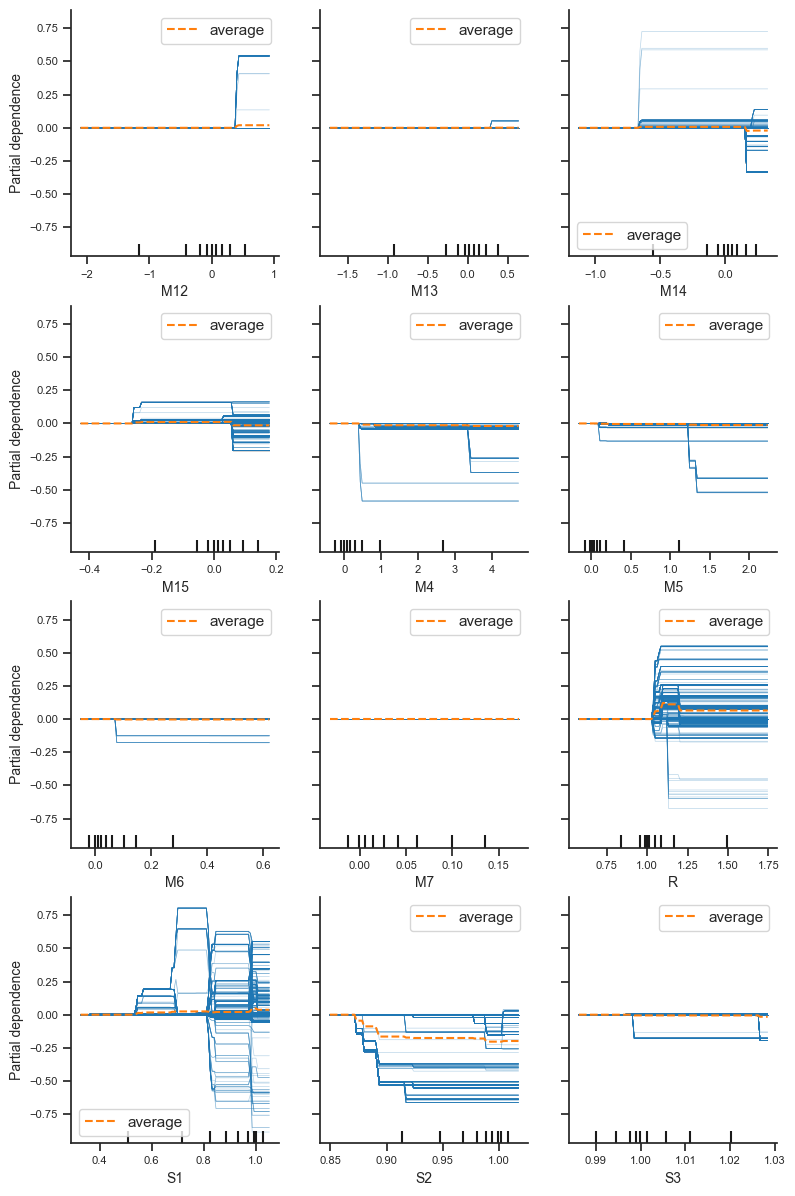

In [17]:
params = {
    "axes.labelsize":10,
    "axes.titlesize":12,
    "font.size":8,
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    'figure.figsize':[8,12]
}
plt.rcParams.update(params)
PartialDependenceDisplay.from_estimator(model_rf, X_train.iloc[:10000, :],
                                        [1,2,3,4,5,6,7,8,9,10,11,12],
                                        feature_names=X_train.columns,
                                        kind="both",
                                        centered=True,
                                        n_jobs=-2,
                                        target=1)
plt.tight_layout()
plt.show()

-> Pour les caractéristiques M6 et M7 par exemple, les courbes ICE sont relativement plates, indiquant un impact limité sur les prédictions, avec des moyennes proches de zéro. En revanche, R ou S1 montrent des variations plus prononcées, avec des courbes ICE qui divergent significativement de la moyenne, suggérant que ces caractéristiques ont un impact plus important et variable sur les prédictions.
S1 montre une forte dispersion des courbes ICE, indiquant que cette caractéristique a un impact très variable selon les instances. S2 montrent des fluctuations notables, suggérant des influences spécifiques selon les valeurs des caractéristiques mais s'étalant sur plusieurs niveaux regroupés : plusieurs courbes vers 0 et plusieurs courbes vers -0.5 suggérant des groupes d'individus présentant des caractéristiques similaires d'un point de vue de la mesure S2.

## Shapley Additive Explanations (SHAP)

<u>Objectif :</u>

SHAP est une méthode qui aide à comprendre comment chaque caractéristique influence les prédictions d'un modèle. Elle attribue une valeur à chaque caractéristique pour montrer son importance dans la prédiction, ainsi pour chaque variables explicative on observe la répartition de l'importance des observations.

<u>Remarque dans notre exercice :</u>

Comme notre exercice est un exercice de regression à sorties multiples (on prédit plusieurs colonnes), on spécifie la variable de sortie pour laquelle on souhaite visualiser les dépendances des variables explicatives, ici 0 pour l'exemple mais on peut répéter l'analyse pour chacune des variables à expliquer.

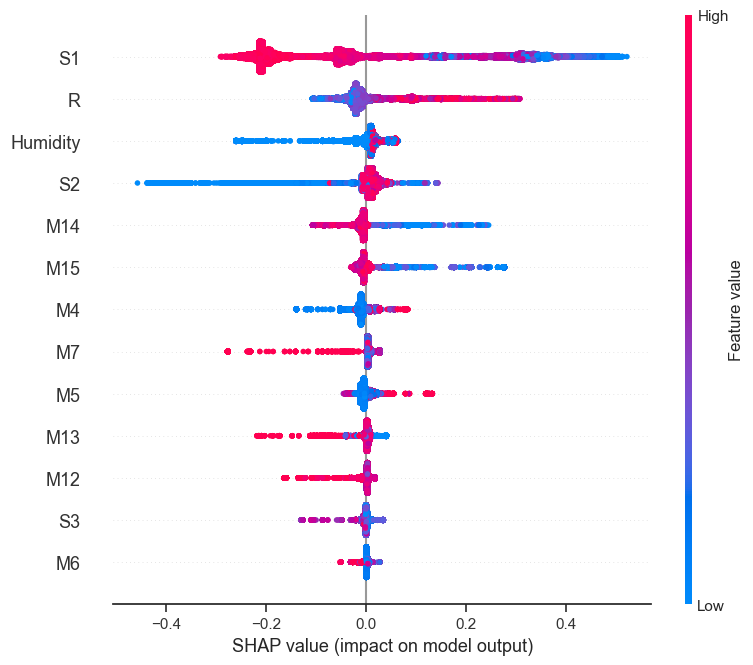

In [38]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train)
shap_values_for_output = shap_values[:, :, 0]
shap.summary_plot(shap_values_for_output, X_train)

-> Ce graphique SHAP illustre l'influence des différentes caractéristiques sur les prédictions d'un modèle. La caractéristique "S1" se distingue par un impact positif significatif, avec des valeurs élevées (en rouge) qui augmentent fortement la prédiction. En revanche, "R" et "S2" présentent des impacts variés, avec des importances de prédiction qui diffèrent en fonction desvaleurs SHAP positives et négatives, indiquant que leur influence dépend de leur valeur spécifique (valeurs positives pour "R" et valeurs proches de 0 pour "S2").
Les caractéristiques comme "M14" et "M15" montrent des impacts plus modérés, avec des distributions de valeurs SHAP plus concentrées autour de zéro.

## Test Pred

In [20]:
# 6. Prédictions finales (sur test_data, si disponible)
X_test = test_data.drop(columns=['ID'])
X_test_scaled   = scaler.transform(X_test)
X_test_poly = poly.transform(X_test_scaled)

In [21]:
# Enregistrement des résultats
test_pred = best_model.predict(X_test_poly)
output = pd.DataFrame(test_pred, columns=[f'c{i}' for i in range(1, 24)])
# Ajouter la colonne "ID" au début
output.insert(0, 'ID', test_data['ID'])
output.to_csv('predictions/best_prediction_Poly.csv', index=False)